In [75]:
library(tidyverse)
library(repr)
library(tidymodels)
library(readxl)
library(httr)
library(jsonlite)
library(ggplot2)
library(GGally)

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



#### Helper functions from Kaggle: https://www.kaggle.com/berent/r-api-for-kaggle-datase/data

In [8]:
kgl_credentials <- function(kgl_json_path){
    
    # returns user credentials from kaggle json
    user <- fromJSON(kgl_json_path, flatten = TRUE)
    return(user)
    
}

In [18]:
kgl_dataset <- function(ref, file_name, type="dataset", kgl_json_path="./data/kaggle_auth.json"){
    
    # ref: depends on 'type':
    # - dataset: "sudalairajkumar/novel-corona-virus-2019-dataset"
    # - competition: competition ID, e.g. 8587 for "competitive-data-science-predict-future-sales"
    # file_name: specific dataset wanted, e.g. "covid_19_data.csv"
    
    .kaggle_base_url <- "https://www.kaggle.com/api/v1"
    user <- kgl_credentials(kgl_json_path)
    
    if(type=="dataset"){
        
        # dataset
        url <- paste0(.kaggle_base_url, "/datasets/download/", ref, "/", file_name)

        
    }else if(type=="competition"){
        
        # competition
        url <- paste0(.kaggle_base_url, "/competitions/data/download/", ref, "/", file_name)
        
    }
    
    # call
    rcall <- httr::GET(url, httr::authenticate(user$username, user$key, type="basic"))
    
    # content type
    content_type <- rcall[[3]]$`content-type`
    
    if( grepl("zip", content_type)){
        
        # download and unzup
        temp <- tempfile()
        download.file(rcall$url,temp)
        data <- read.csv(unz(temp, file_name))
        unlink(temp)
        
    }else{
        
        # else read as text -- note: code this better
        data <- content(rcall, type="text/csv", encoding = "ISO-8859-1")
    }

    return(data)
    
}

### Download Pulsar Data

In [62]:
pulsar_data <- kgl_dataset("colearninglounge/predicting-pulsar-starintermediate", 
                               "pulsar_data_train.csv") %>% 
                mutate(target_class = as_factor(target_class))
pulsar_unclassified <- kgl_dataset("colearninglounge/predicting-pulsar-starintermediate", 
                               "pulsar_data_test.csv") 
pulsar_data %>% head(5)

Parsed with column specification:
cols(
  `Mean of the integrated profile` = col_double(),
  `Standard deviation of the integrated profile` = col_double(),
  `Excess kurtosis of the integrated profile` = col_double(),
  `Skewness of the integrated profile` = col_double(),
  `Mean of the DM-SNR curve` = col_double(),
  `Standard deviation of the DM-SNR curve` = col_double(),
  `Excess kurtosis of the DM-SNR curve` = col_double(),
  `Skewness of the DM-SNR curve` = col_double(),
  target_class = col_logical()
)



,Mean.of.the.integrated.profile,Standard.deviation.of.the.integrated.profile,Excess.kurtosis.of.the.integrated.profile,Skewness.of.the.integrated.profile,Mean.of.the.DM.SNR.curve,Standard.deviation.of.the.DM.SNR.curve,Excess.kurtosis.of.the.DM.SNR.curve,Skewness.of.the.DM.SNR.curve,target_class
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,121.15625,48.37297,0.3754847,-0.01316549,3.168896,18.39937,7.449874,65.159298,0
2,76.96875,36.17556,0.7128979,3.38871856,2.399666,17.57100,9.414652,102.722975,0
3,130.58594,53.22953,0.1334083,-0.29724164,2.743311,22.36255,8.508364,74.031324,0
4,156.39844,48.86594,-0.2159886,-0.17129365,17.471572,NA,2.958066,7.197842,0
5,84.80469,36.11766,0.8250128,3.27412537,2.790134,20.61801,8.405008,76.291128,0


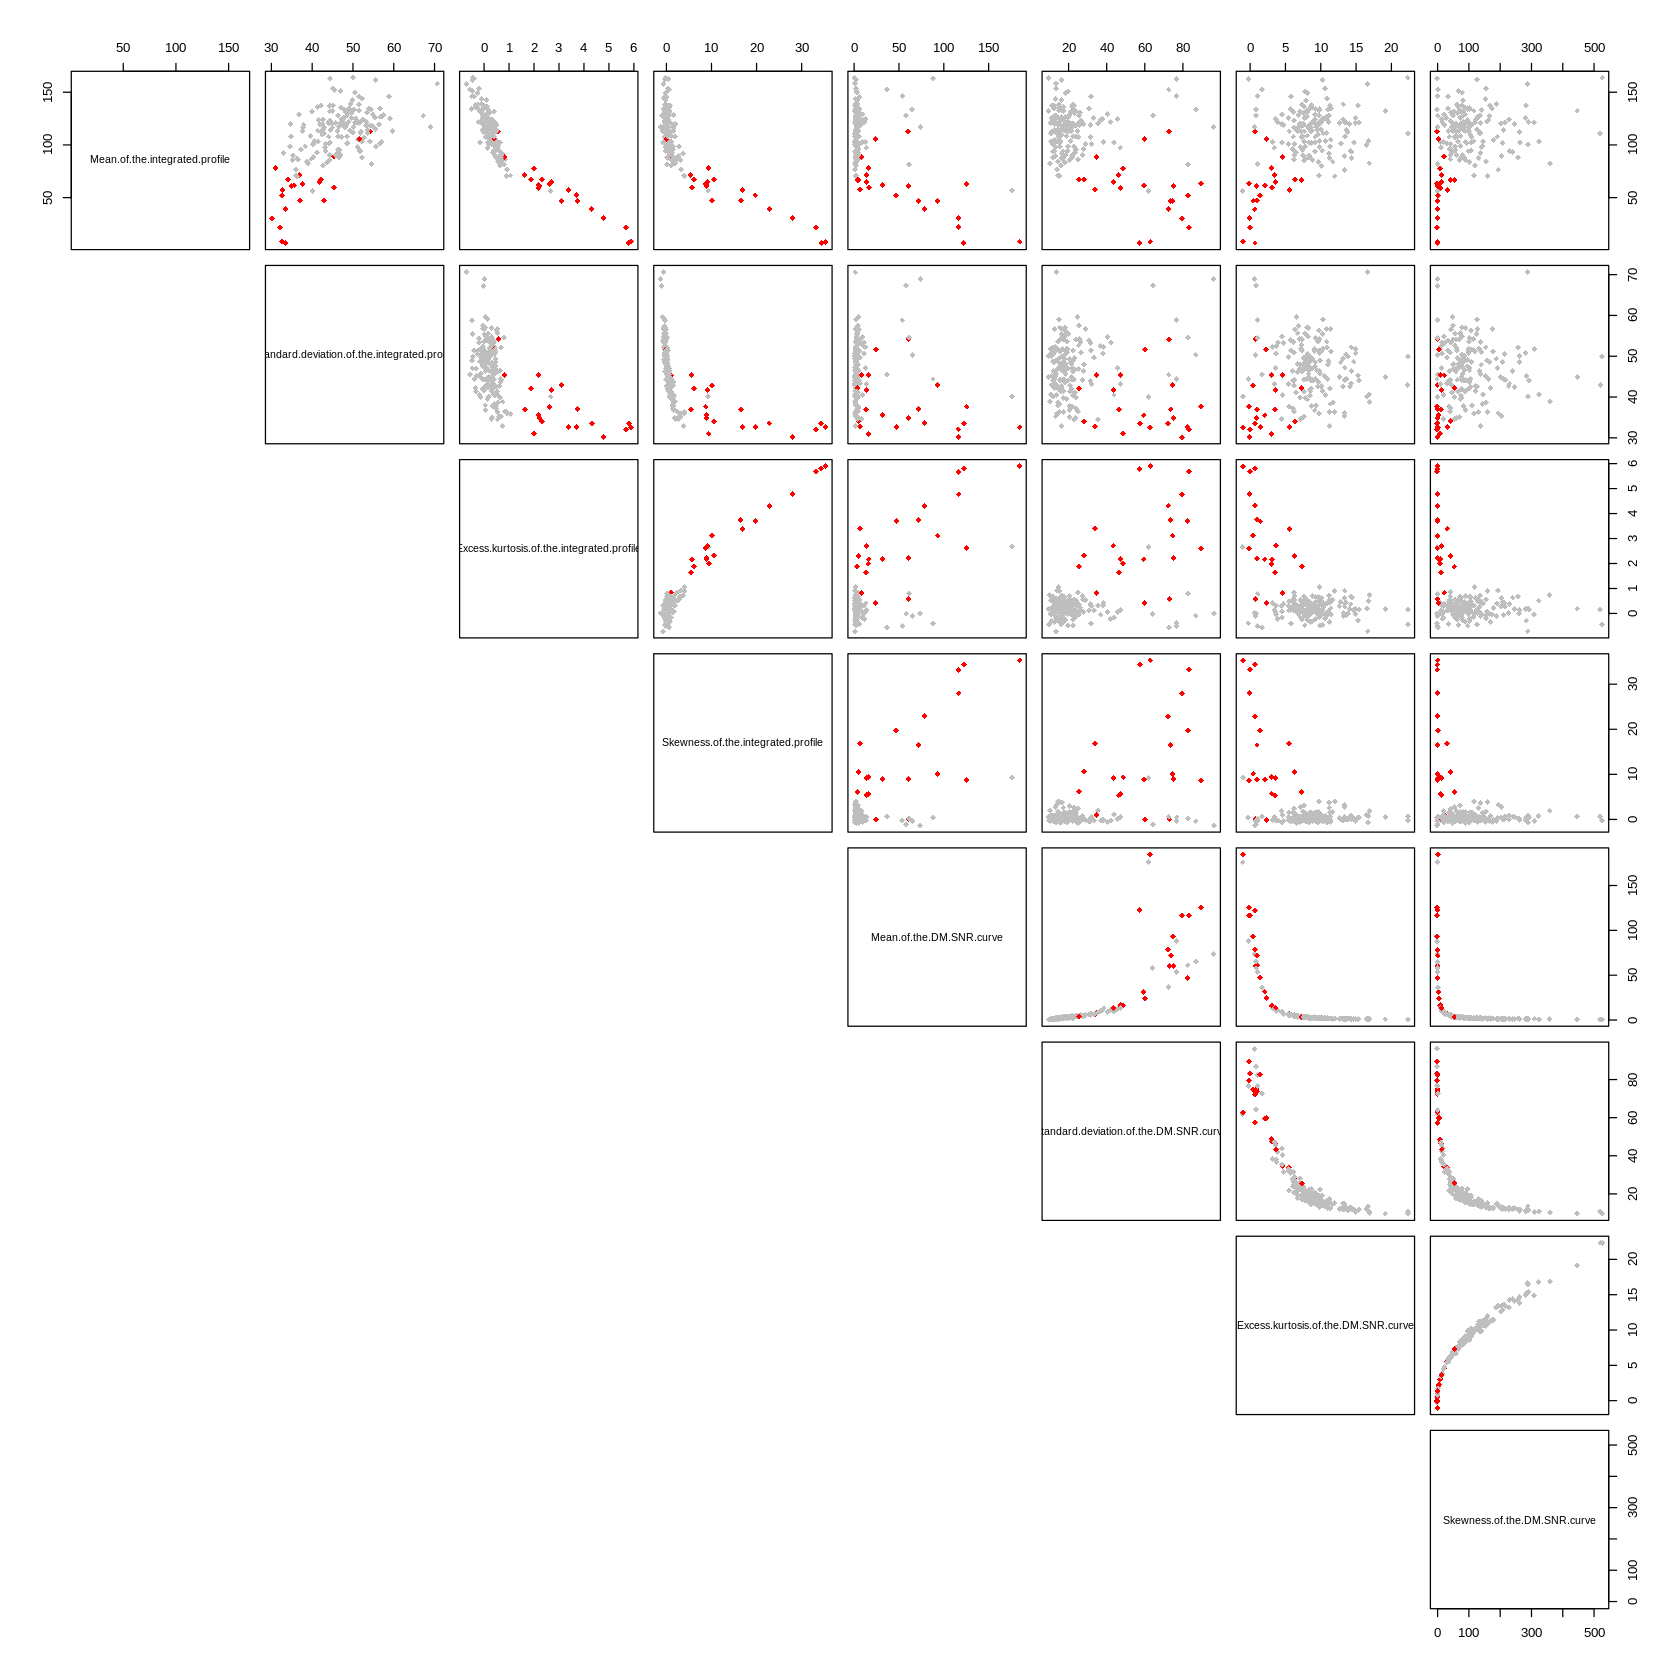

In [72]:
options(repr.plot.width = 14, repr.plot.height = 14)


# subset of the data
pulsar_subset <- pulsar_data %>% 
                  sample_n(250) %>% 
                  na.omit()

# assign colors based on the subset target_class
colors <- c('grey', 'red')[unclass(pulsar_subset$target_class)]


pairs(pulsar_subset %>% select(Mean.of.the.integrated.profile:Skewness.of.the.DM.SNR.curve),
      col=colors,
      pch = 18,
      lower.panel = NULL)

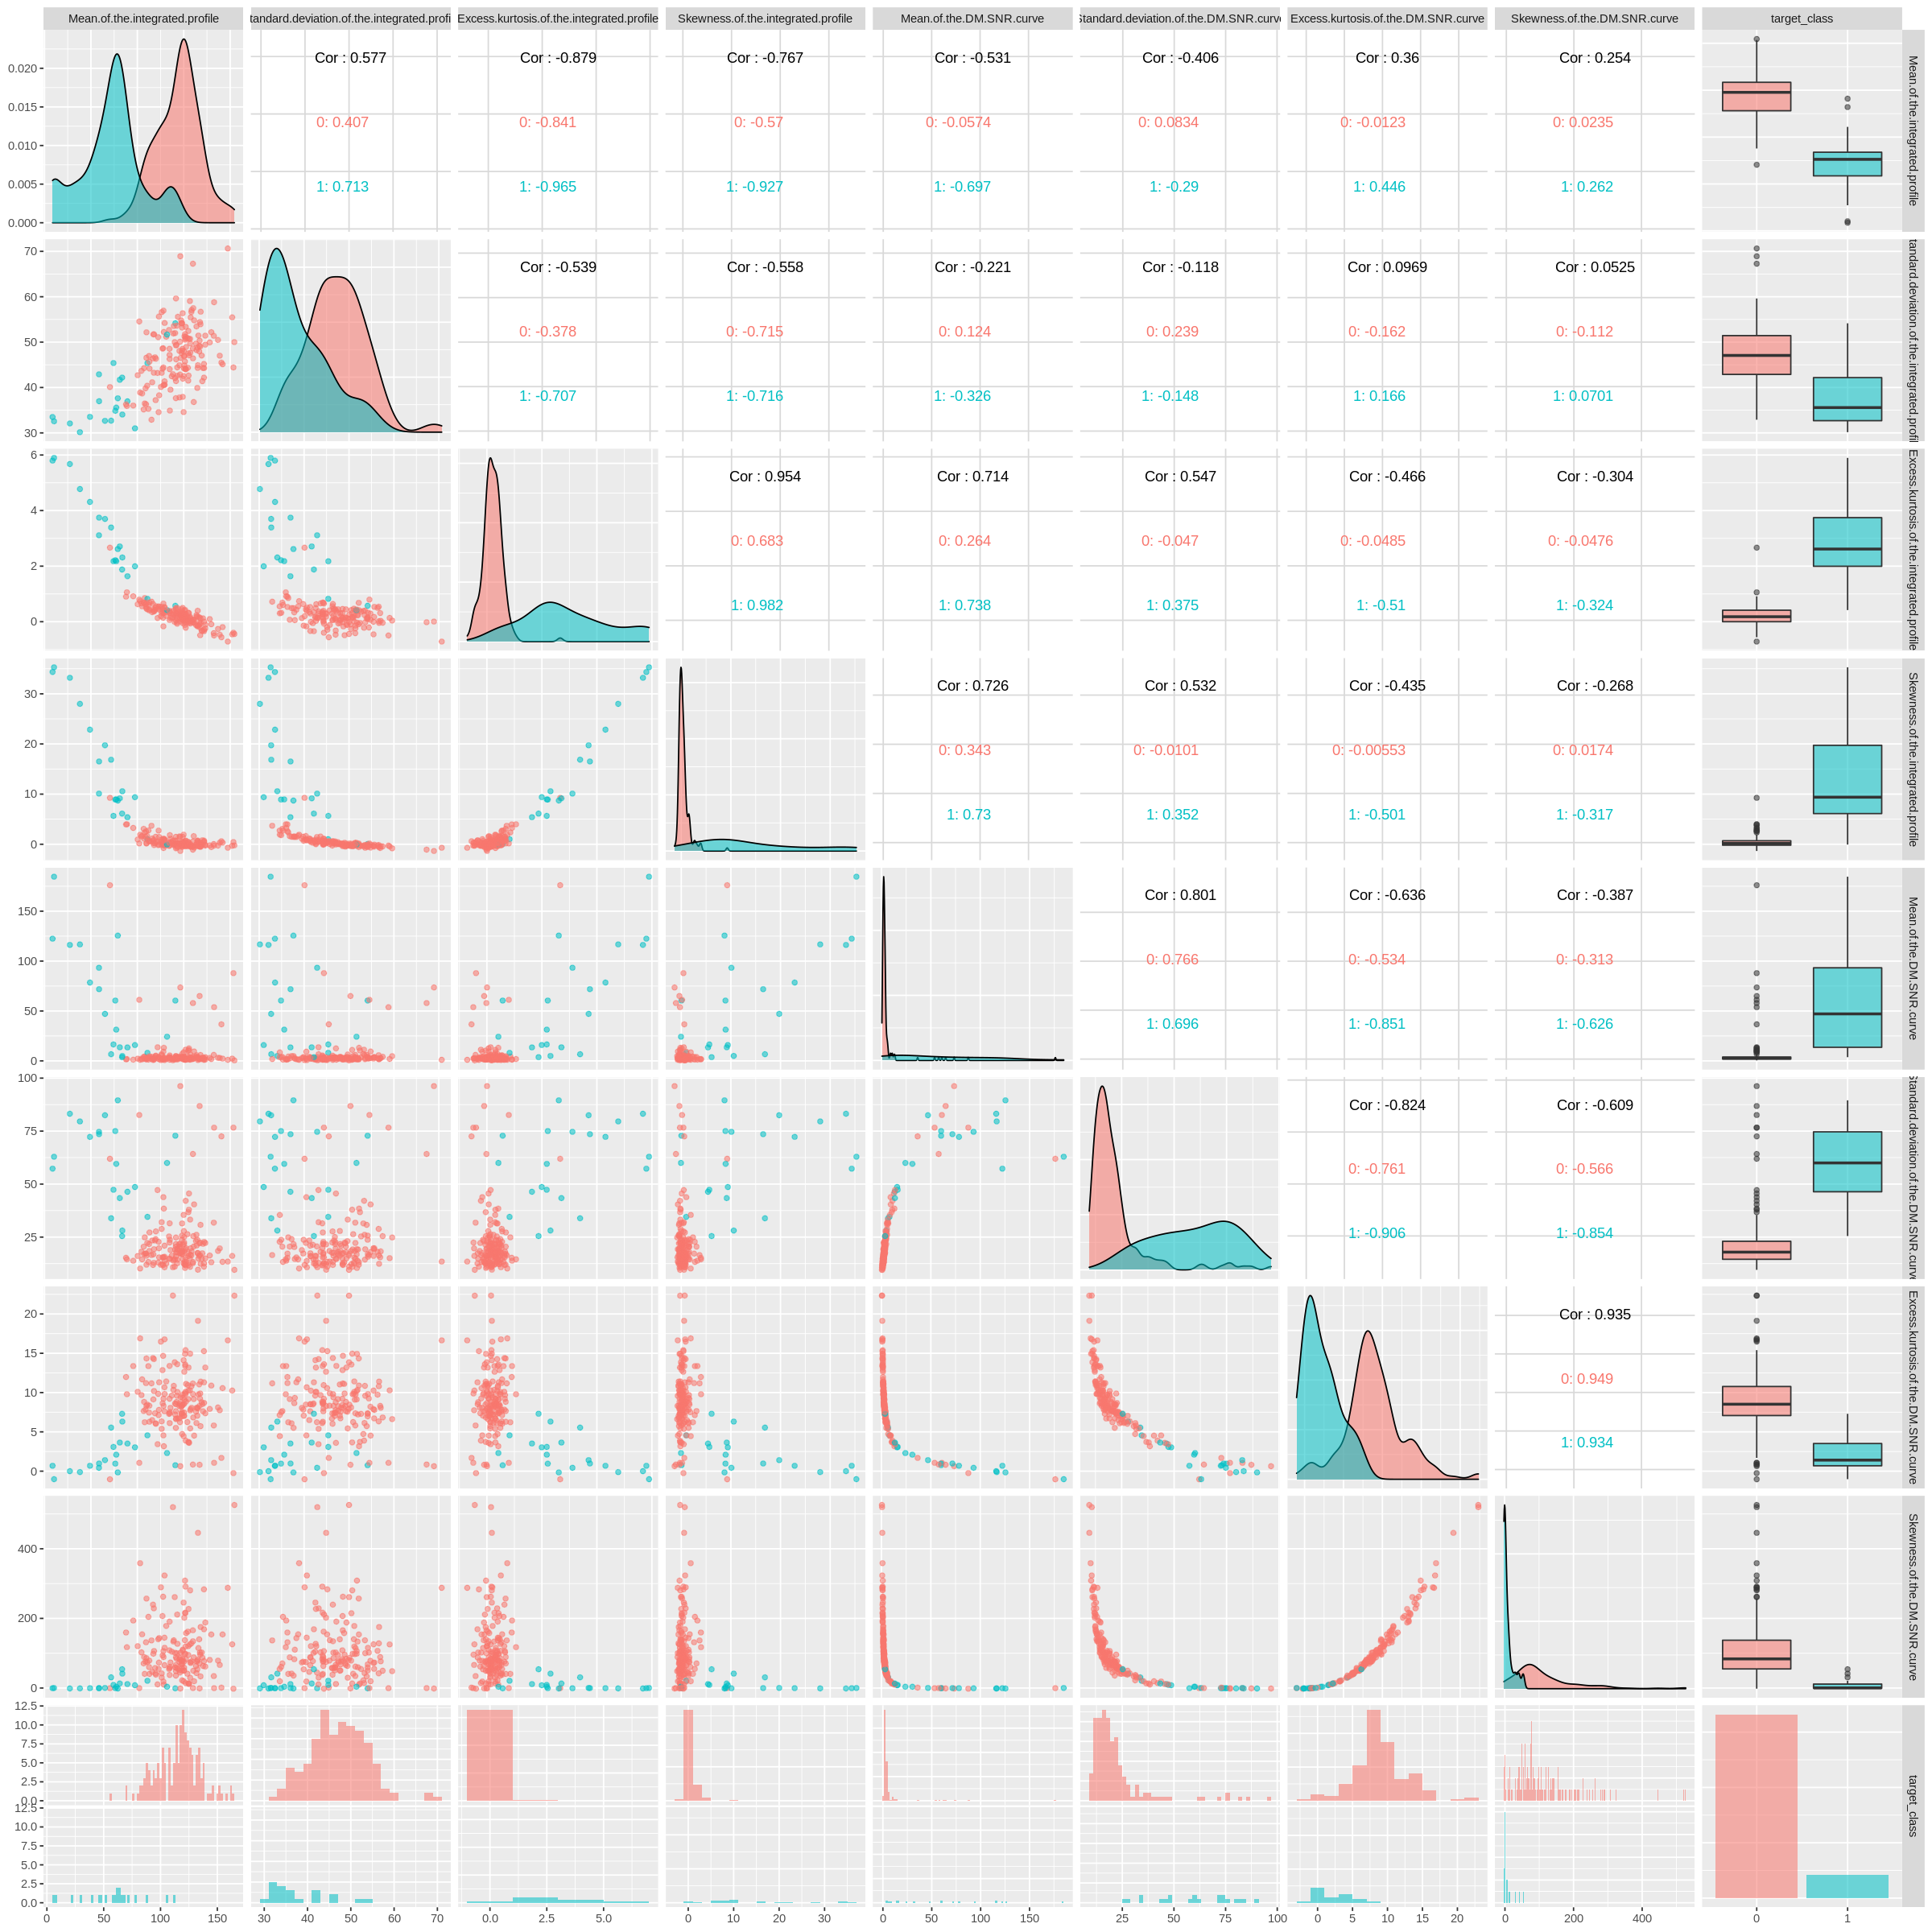

In [90]:
options(repr.plot.width = 20, repr.plot.height = 20)
ggpairs(pulsar_subset,
           mapping = aes(color=target_class, alpha = 0.3),
           lower=list(combo=wrap("facethist",  
                      binwidth=2)))